# Import Library & Dataset

In [1]:
# Import libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Load dataset
def load_parquet_files(file_paths):
    dataframes = [pd.read_parquet(file, engine = "pyarrow") for file in file_paths]
    return pd.concat(dataframes, ignore_index = True)

parquet_files = ["train-00000-of-00007-bc5952582e004d67.parquet", 
                 "train-00001-of-00007-71c80017bc45f30d.parquet", 
                 "train-00002-of-00007-ee2d43f396e78fbc.parquet", 
                 "train-00003-of-00007-529931154b42b51d.parquet", 
                 "train-00004-of-00007-b269dc49374a2c0b.parquet", 
                 "train-00005-of-00007-3dce5e05ddbad789.parquet",
                 "train-00006-of-00007-3d8a471ba0cf1c8d.parquet"
                ]

df_full = load_parquet_files(parquet_files)
df_full.head()

,source,id,text
0,human,0,12 Years a Slave: An Analysis of the Film Essa...
1,human,1,20+ Social Media Post Ideas to Radically Simpl...
2,human,2,2022 Russian Invasion of Ukraine in Global Med...
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...


In [3]:
# Full dataset's shape
df_full.shape

(1392522, 3)

In [4]:
# Define the sample size 
sample_fraction = 0.01  
df, _ = train_test_split(df_full, train_size = sample_fraction, stratify = df_full['source'], random_state = 1)
df = df.reset_index(drop = True)
df.shape

(13925, 3)

# IDE

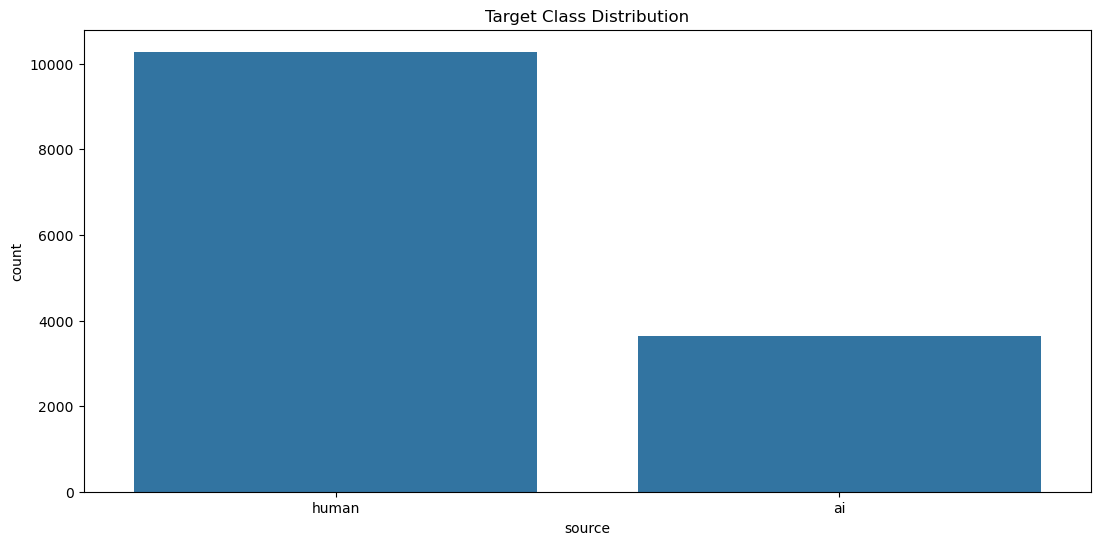

In [5]:
# Class distribution
f, ax = plt.subplots(figsize = (13, 6))
sns.countplot(x = 'source', data = df)
plt.title("Target Class Distribution")
plt.show()

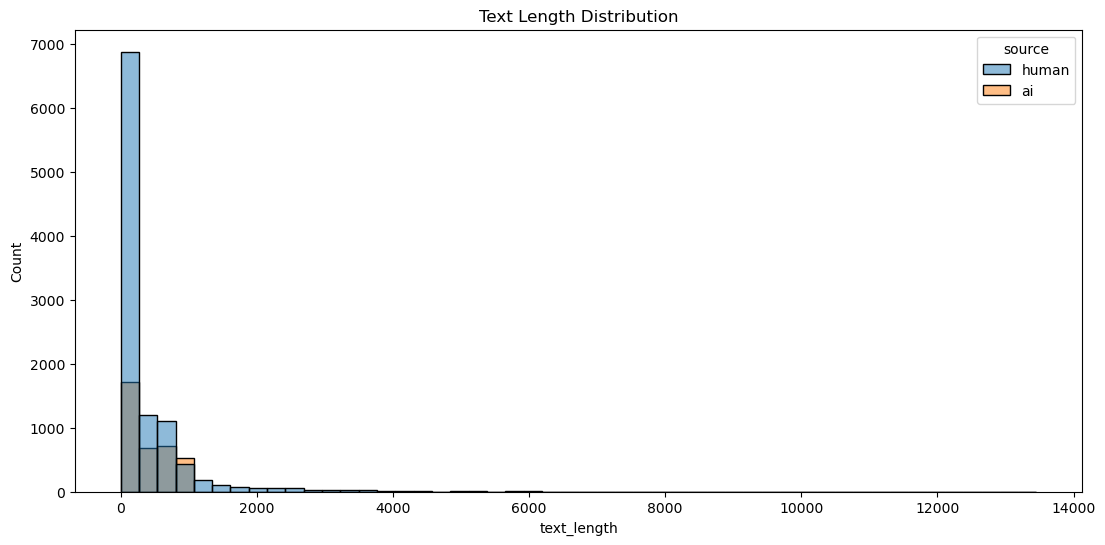

In [6]:
# Text length analysis
f, ax = plt.subplots(figsize = (13, 6))
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df, x = 'text_length', hue = 'source', bins = 50)
plt.title("Text Length Distribution")
plt.show()

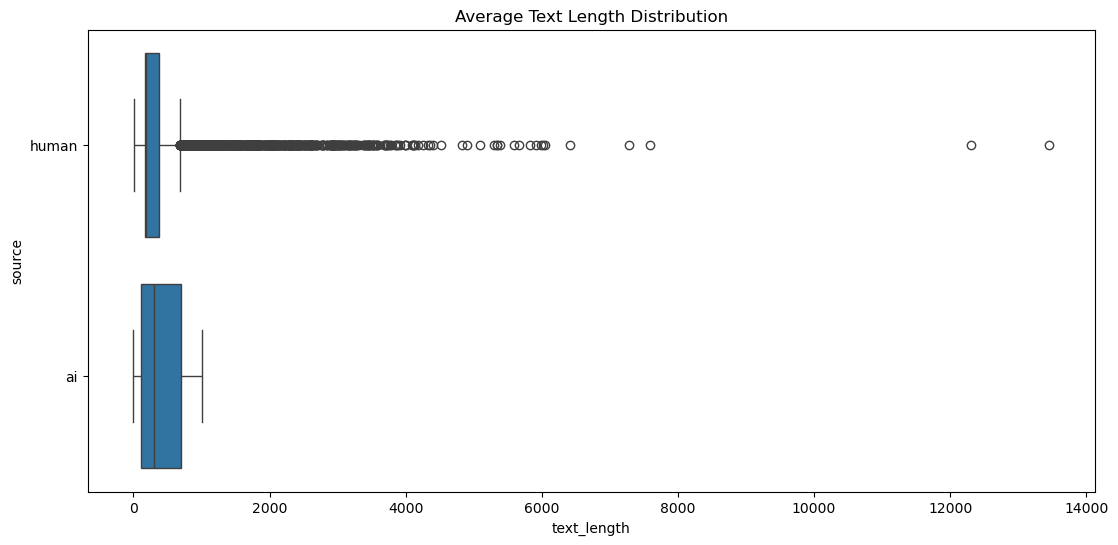

In [7]:
# Average text length analysis
f, ax = plt.subplots(figsize = (13, 6))
sns.boxplot(df, x = 'text_length', y = 'source')
plt.title("Average Text Length Distribution")
plt.show()

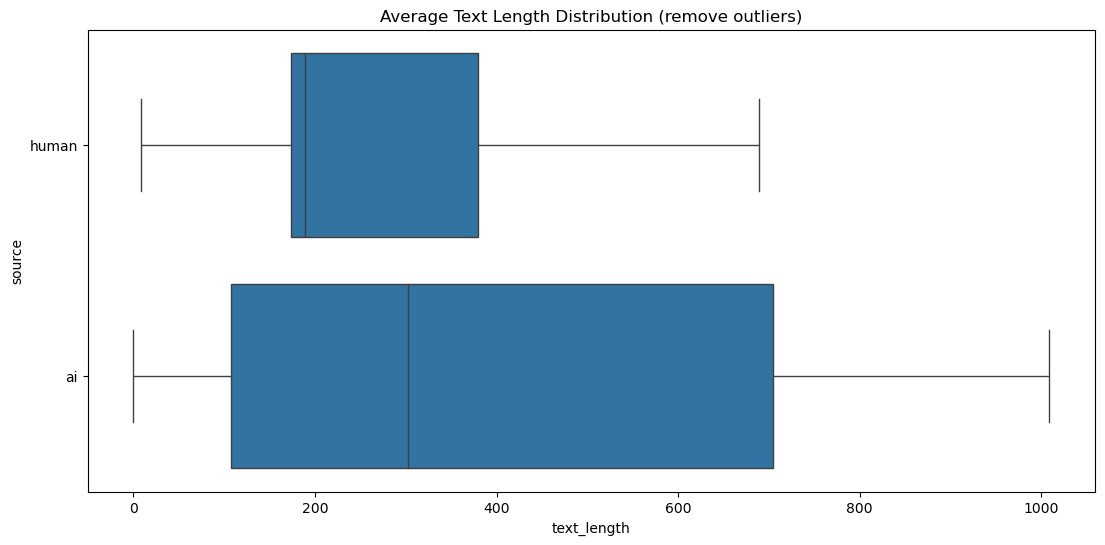

In [8]:
# Average text length analysis without outliers
f, ax = plt.subplots(figsize = (13, 6))
sns.boxplot(df, x = 'text_length', y = 'source', showfliers = False)
plt.title("Average Text Length Distribution (remove outliers)")
plt.show()

In [9]:
# Text length distribution
df.groupby("source")[['source', 'text_length']].describe()

text_length                                                            
             count        mean         std  min     25%    50%    75%      max
source                                                                        
ai          3644.0  387.933315  299.162296  0.0  107.75  302.0  705.0   1009.0
human      10281.0  403.937749  577.402107  8.0  174.00  189.0  380.0  13456.0

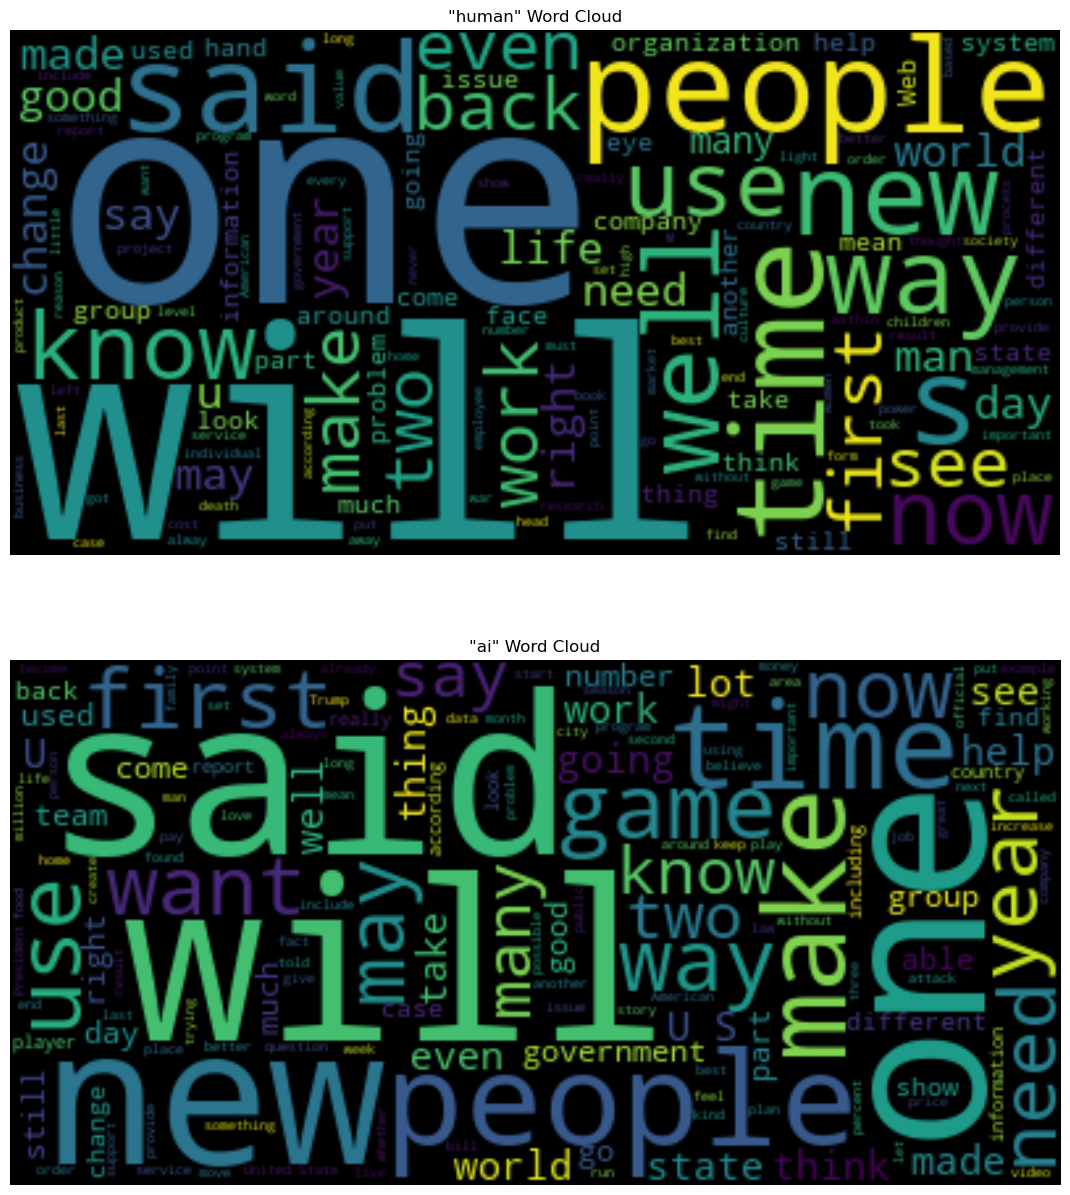

In [10]:
# Word cloud (only contains the first 1000 rows of each label)
fig, axs = plt.subplots(2,1, figsize = (100, 15))
for i in range(len(df['source'].unique())):
    txt = ' '.join(df[df['source'] == df['source'].unique()[i]]['text'].head(1000).astype(str))
    wordcloud = WordCloud().generate(txt)
    title = '"' + df['source'].unique()[i] + '"' + ' Word Cloud'
    
    axs[i].imshow(wordcloud, interpolation = 'bilinear')
    axs[i].axis("off")
    axs[i].set_title(title)

# Text Preprocessing

In [11]:
# Text Sample
print(df['text'][0])

``Mr..... Sameson?'' 
 
 ``That's me.'' 
 
 ``Well, hello Mr. Sameson,'' said the chubby guy with the blond slick sideways hair, ``Foggy Nelson, Nelson and Murdock. This is my partner, Matthew Murdock.'' 
 
 Matthew came walking in slightly clumsy, holding a suitcase in his left hand and a blind man's cane in his right. He wore glasses that obscured his eyes. Blind. What a shame, everyone can appreciate his looks but himself. I took his hand and shook it. Quite a grip for a blind man. Does he work out? 
 
 ``We are here to help you and represent you in your current dilemma concerning the Tilton boys. ``, Foggy said as he sat his plump down and pulled a file out. Matthew took out a laptop. 
 
 ``Can you recount what happened yesterdaynight around 3:00 AM, sir? ``, Matthew asked me in one of those cold lawyer voices. Kinda weird how he doen't look at you. As if you're in between walls with the guy, but he knows you're there. 
 
 ``They tried to rob me. I took a gun out of the


In [12]:
# Basic text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', '', text)  # Remove newline characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['clean_text'] = df['text'].apply(preprocess_text)
df = df[df['clean_text'].str.len() > 5]
df = df.reset_index(drop = True)

In [13]:
df = df.dropna(subset=['clean_text'])  # Remove rows where 'clean_text' is NaN
df = df[df['clean_text'].str.strip() != '']  # Remove empty strings

In [14]:
# TF-IDF feature extraction
vectorizer = TfidfVectorizer(max_features = 5000, stop_words = 'english', ngram_range = (1, 2))
X = vectorizer.fit_transform(df['clean_text'])
y = df['source'].map({'human': 0, 'ai': 1})

In [15]:
# # Handling class imbalance using SMOTE
# smote = SMOTE(random_state = 1)
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [16]:
ros = RandomOverSampler(sampling_strategy = 'minority', random_state = 1)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

# Model Training

In [18]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier()
}

In [19]:
for name, clf in classifiers.items():
    # Train (fit) the model
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate performance metrics
    print(f"===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Human", "AI"]))
    print("\n")

===== Logistic Regression =====
Accuracy: 0.8774617067833698
Classification Report:
              precision    recall  f1-score   support

       Human       0.92      0.83      0.87      2031
          AI       0.85      0.93      0.88      2082

    accuracy                           0.88      4113
   macro avg       0.88      0.88      0.88      4113
weighted avg       0.88      0.88      0.88      4113



===== Random Forest =====
Accuracy: 0.9226841721371262
Classification Report:
              precision    recall  f1-score   support

       Human       0.95      0.89      0.92      2031
          AI       0.90      0.96      0.93      2082

    accuracy                           0.92      4113
   macro avg       0.93      0.92      0.92      4113
weighted avg       0.92      0.92      0.92      4113



===== Gradient Boosting =====
Accuracy: 0.8397763189885729
Classification Report:
              precision    recall  f1-score   support

       Human       0.92      0.74      0.82

In [21]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize the base RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                
    scoring='accuracy',  
    n_jobs=-1,           
    verbose=2            
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [22]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Retrieve the best estimator
best_rf = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Human", "AI"]))

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.9204814242187045
Test Accuracy: 0.9358132749817651
Classification Report:
              precision    recall  f1-score   support

       Human       0.94      0.92      0.93      2031
          AI       0.93      0.95      0.94      2082

    accuracy                           0.94      4113
   macro avg       0.94      0.94      0.94      4113
weighted avg       0.94      0.94      0.94      4113

